# Mixed-layer depth

de Boyer Montegut et al., 2004

reference depth

smooth profiles

different criteria
potential temperature exceeds threshold
potential density 

$$ \text{MLD is the depth, where } $$

\begin{equation}
\Delta \theta = \theta_d - \theta_s \gt 0.2 ^{\circ}C
\end{equation}

\begin{equation}
\Delta \sigma_0 = \sigma_{0,d} - \sigma_{0,s} \gt 0.03 \text{ kgm}^{-3}
\end{equation}

exception when mld is not found with both criteria, than it takes the mixed layer depth at the density difference

\begin{equation}
\Delta \theta \text{ and } \Delta \sigma_0
\end{equation}

variable criteria

\begin{eqnarray}
\delta \sigma_0 = \sigma_0(\theta_s - 0.2^{\circ}\text{C}, S_{A,s}, p_s) - \sigma_0(\theta_s, S_{A,s}, p_s) \\
\Delta \sigma_0 = \sigma_{0,d} - \sigma_{0,s} \gt \delta \sigma_0
\end{eqnarray}


In [1]:
%run ../../_setup.py

import numpy as np
from netCDF4 import Dataset

# %matplotlib notebook
import matplotlib.pyplot as plt

input_file_ctd = os.path.join(datadir, 'processed', 'ss9802', 'netcdf', 'ss9802_ctd_gsw.nc')
ctd = Dataset(input_file_ctd)

ctd.variables.keys()


odict_keys(['ts_lat', 'station', 'depth', 'bot_lat', 't', 'lat', 'bot_lon', 'O2', 'ts_t', 'SP', 'time', 'lon', 'ts_SP', 'p', 'ts_lon', 'ts_O2', 'latv', 'pt', 'SA', 'Vg', 'spiciness0', 'lonv', 'z', 'g', 'CT', 'deltaD', 'sigma0', 'gamman'])

In [2]:
def mixed_layer_depth(z, sig0=False, pt=False, SA=False, CT=False, smooth=False):

    # The reference depth is to avoid large part of the strong diurnal cycle in the top few meters of the ocean. 
    # Dong et al. 2008 suggests that 20 m is a sensible determination of "near surface" in the Southern Ocean.
    ref = 20
    iref, ref_dep = min(enumerate(z), key=lambda x: abs(abs(x[1]) - ref))
#     print('reference depth: %s' %ref_dep)

    # smooth profiles with moving average
    if sig0 is not False:
        if smooth:
            N = 5
            sig0 = np.concatenate([np.mean(sig0[:N - 1]) * np.ones(N - 1, ),
                                   np.convolve(sig0.data, np.ones((N,)) / N, mode='valid')])
            sig0 = np.ma.masked_where(sig0 > 1e36, sig0)

        # near-surface value
        sig0_s = sig0[iref]

    if pt is not False:
        if smooth:
            N = 5
            pt = np.concatenate([np.mean(pt[:N - 1]) * np.ones(N - 1, ),
                                 np.convolve(pt.data, np.ones((N,)) / N, mode='valid')])
            pt = np.ma.masked_where(pt > 1e36, pt)

        # near-surface values
        pt_s = pt[iref]

    # Mixed Layer Depth based on de Boyer Montegut et al. 2004's property difference based criteria
    # MLD in potential density difference, fixed threshold criterion (sig0_d - sig0_s) > 0.03 kg/m^3
    if sig0 is not False and SA is False and CT is False:
        imld = iref + next((i for i in range(len(sig0[iref:]))
                            if sig0[i] - sig0_s > 0.03), np.nan)

    # MLD in potential temperature difference, fixed threshold criterion abs(pt_d - pt_s) > 0.2°C
    if pt is not False:
        imld = iref + next((i for i in range(len(pt[iref:]))
                            if abs(pt[i] - pt_s) > 0.2), np.nan)

    # MLD in potential density and potential temperature difference
    if sig0 is not False and pt is not False:
        imld = iref + next((i for i in range(len(sig0[iref:]))
                            if 0.03 < abs(sig0[i] - sig0_s) < 0.125
                            and 0.2 < abs(pt[i] - pt_s) < 1),
                           next(i for i in range(len(sig0[iref:]))
                                if sig0[i] - sig0_s > 0.03))

    # MLD in potential density with a variable threshold criterion
    if sig0 is not False and SA is not False and CT is not False:
        SA_s = SA[iref]
        CT_s = CT[iref]
        dsig0 = sigma0(SA_s, CT_s - 0.2) - sigma0(SA_s, CT_s)
        imld = iref + next((i for i in range(len(sig0[iref:]))
                            if sig0[i] - sig0_s > dsig0), np.nan)

    return imld, sig0, pt

## Questions
1. Should the reference depth be interpolated to exactly 20m?
2. 

In [3]:
# input_file_adcp = os.path.join(datadir, 'processed', 'ss9802', 'netcdf', 'ss9802_adcp_ctd.nc')
# input_file_ctd = os.path.join(datadir, 'processed', 'ss9802', 'netcdf', 'ss9802_ctd_gsw.nc')

# adcp = Dataset(input_file_adcp)
# ctd = Dataset(input_file_ctd)



In [4]:
nst = ctd.dimensions['profile'].size

smooth = True
imld = []
for ist in range(nst):
    
    # read variables
    sig0 = ctd['sigma0'][ist,]
    pt = ctd['pt'][ist,]
    z = ctd['z'][ist,]

    # determine index of mixed layer depth 
    imld_tdd = mixed_layer_depth(z, sig0=sig0, pt=pt, smooth=smooth)[0]
    imld.append(imld_tdd)
    
# # construct adcp pressure levels
# padcp = np.linspace(np.nanmin(adcp['p'][:]), np.nanmax(adcp['p'][:]), adcp.dimensions['plevel'].size)

# # find reference depth
# ref = 20
# iref, ref_dep = min(enumerate(padcp), key=lambda x: abs(x[1] - ref))
# print('ADCP reference depth: %s' %ref_dep)

# find pressure of mixed layer depth
mlp = [ctd['p'][i] for i in imld]
mlgmn = np.array([ctd['gamman'][st, i] for st, i in enumerate(imld)])
# imldadcp = [(np.abs(padcp - p)).argmin() for p in mlp]
# pmldadcp = [padcp[i] for i in imldadcp]


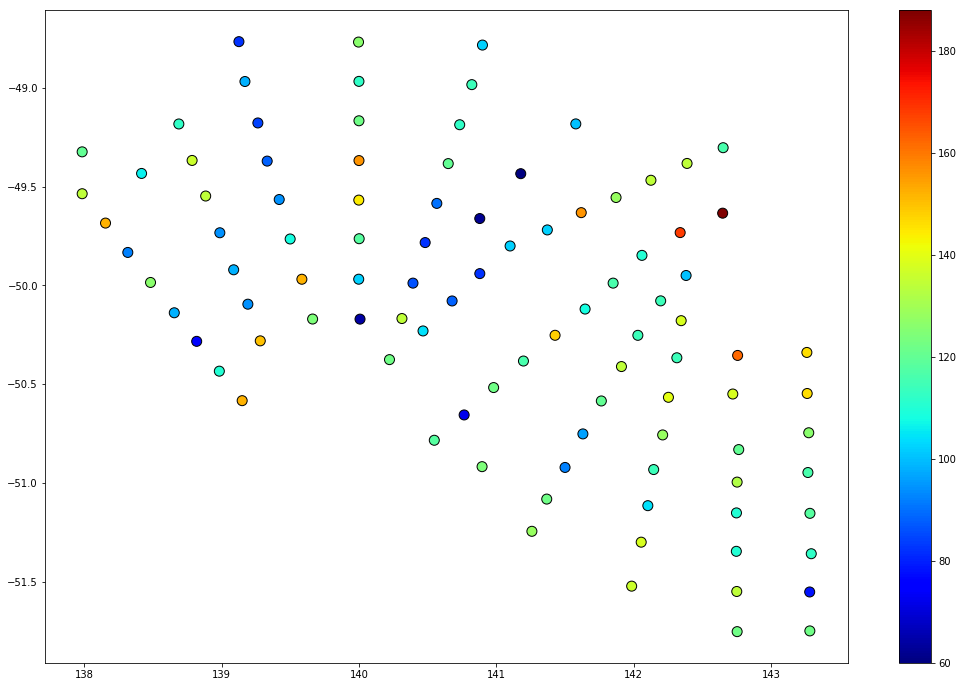

In [5]:
fig, ax = plt.subplots(figsize=(18, 12))
scat = ax.scatter(ctd['lon'][2:, 0], ctd['lat'][2:, 0], c=mlp[2:], s=100, cmap=plt.cm.jet, edgecolors='k')
plt.colorbar(scat)

# Layer thickness

In [6]:

import math
from scipy.interpolate import interp1d

def layer_thickness(sigma0, z):

    if sigma0.shape != z.shape:
        raise ValueError('The shape of sigma0 and z should match, found %s and %s' % (sigma0.shape, z.shape))

    # Number of profiles
    if sigma0.ndim == 1:
        sigma0 = sigma0[np.newaxis, :]
        z = z[np.newaxis, :]
    nprofiles = sigma0.shape[0]

    # initialise layer thickness variables
    dz = np.ma.masked_all(sigma0.shape)

    # function to determine lower (upper) limits of variable and round down (up) 
    def limits(var, ndec=None):
        minvar, maxvar = np.nanmin(var), np.nanmax(var)
        if ndec:
            minvar = math.floor(minvar * 10**(ndec)) / (10**ndec)
            maxvar = math.ceil(maxvar * 10**(ndec)) / (10**ndec)
        return minvar, maxvar    

    # make a linear spaced array for sigma0, with a small step size
    minvar, maxvar = limits(sigma0, ndec=2)
    step = 0.001
    sigma0_lin = np.linspace(minvar, maxvar, int((maxvar - minvar) / step + 1))

    # bin to make monotonically increasing sigma0
    bins = np.linspace(minvar, maxvar, sigma0.shape[1] + 1)
    ibin = np.digitize(sigma0_lin, bins)

    for profile in range(nprofiles):

        # interpolate pressure or depth to linear spaced sigma0
        f = interp1d(sigma0[profile], z[profile], bounds_error=False, fill_value=(np.nan, np.nan))
        zinterp = f(sigma0_lin)

        if np.isfinite(zinterp[-1]):
            idx = np.where(zinterp == zinterp[-1])[0]
            if len(idx) > 1:
                zinterp[idx[1:]] = np.nan

        # average interpolated values over bin
        sigma0bin = [sigma0_lin[ibin == i].mean() for i in range(1, len(bins))]
        zbin = [zinterp[ibin == i].mean() for i in range(1, len(bins))]

        # determine dz between depths
        dz[profile] = abs(np.gradient(zbin))
        
    return sigma0bin, dz


In [7]:
transects = {1: list(reversed(range(2, 10))), 2: list(range(10, 18)), 3: list(reversed(range(18, 27))),
             4: list(range(26, 34)), 5: list(reversed(range(36, 46))), 6: list(range(46, 57)),
             7: list(reversed(range(56, 65))), 8: list(reversed(range(68, 76))), 9: list(range(76, 84)),
             10: list(reversed(range(84, 91))), 11: list([93, 92] + list(range(94, 101)))}

In [8]:
# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p'][:]):
    pressure_levels[p] = ip

# define reference and interest level 
# p_ref = 1494
p_int = 2

# get dynamic height contours
D = np.array([ctd['deltaD'][profile, pressure_levels[p_int]] / 
              ctd['g'][profile, pressure_levels[p_int]]
              for profile in range(len(ctd.dimensions['profile']))])

gamman = np.ma.masked_invalid(ctd['gamman'])
gammani = np.linspace(gamman.min(), gamman.max(), ctd['p'].size)

stations = transects[4]


/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Warning: converting a masked element to nan.
  del sys.path[0]


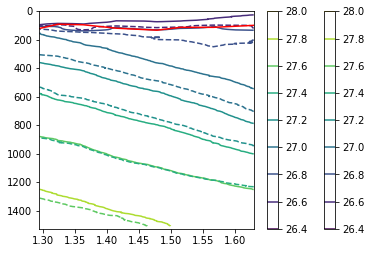

In [13]:
bounds = np.linspace(26.4, 28, 9)
fig, ax = plt.subplots()
cont = ax.contour(D[stations], ctd['p'][:], ctd['gamman'][stations,].T, bounds)
plt.colorbar(cont)
cont2 = ax.contour(D[stations], ctd['p'][:], ctd['sigma0'][stations,].T, bounds, linestyles='--')
plt.colorbar(cont2)
ax.plot(D[stations], np.array(mlp)[stations], 'r')
ax.invert_yaxis()


/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


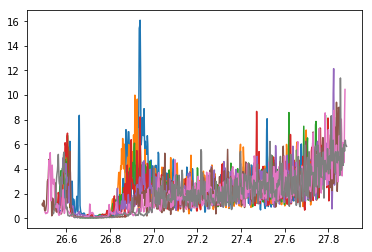

In [10]:
sigma0_lin, dz = layer_thickness(ctd['gamman'][stations], ctd['z'][stations])

plt.figure()
for profile in range(dz.shape[0]):
    plt.plot(sigma0_lin, dz[profile])
# plt.plot(sigma0bin, dz[1])

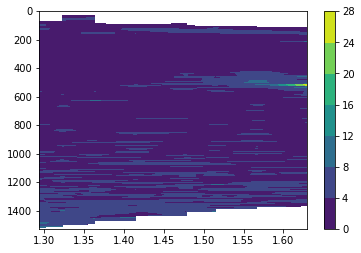

In [11]:
# fig, ax = plt.subplots()
# cf = ax.contourf(D[stations], ctd['p'][:], dz.T)
# # ax.plot(D[stations], np.array(mlp)[stations], 'r')
# ax.invert_yaxis()
# plt.colorbar(cf)

/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


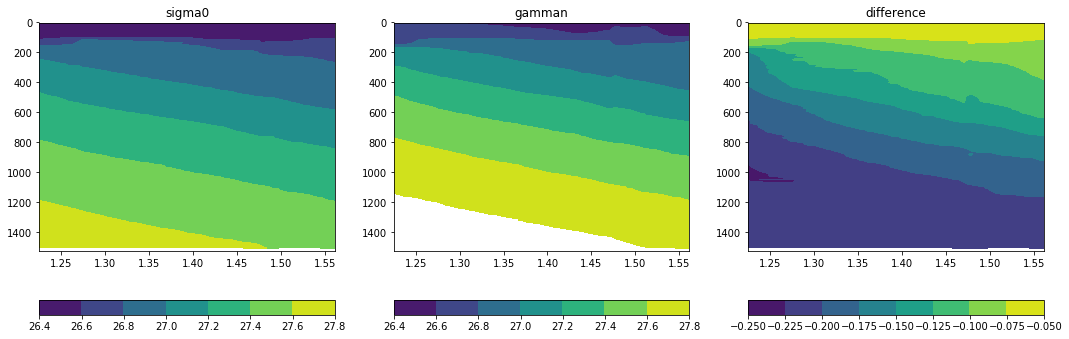

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
for i, var in enumerate(['sigma0', 'gamman', 'difference']):
    if var == 'difference':
        diff = ctd['sigma0'][stations,:] - ctd['gamman'][stations,:]
        cf = ax[i].contourf(D[stations], ctd['p'][:], diff.T)
    else:
        cf = ax[i].contourf(D[stations], ctd['p'][:], ctd[var][stations,:].T, np.linspace(26.4, 27.8, 8))
    plt.colorbar(cf, ax=ax[i], orientation='horizontal')
    ax[i].invert_yaxis()
    ax[i].set_title(var)


In [27]:
np.nanmin(D), np.nanmax(D)

(1.1428189791375605, 1.7175590221144612)

/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


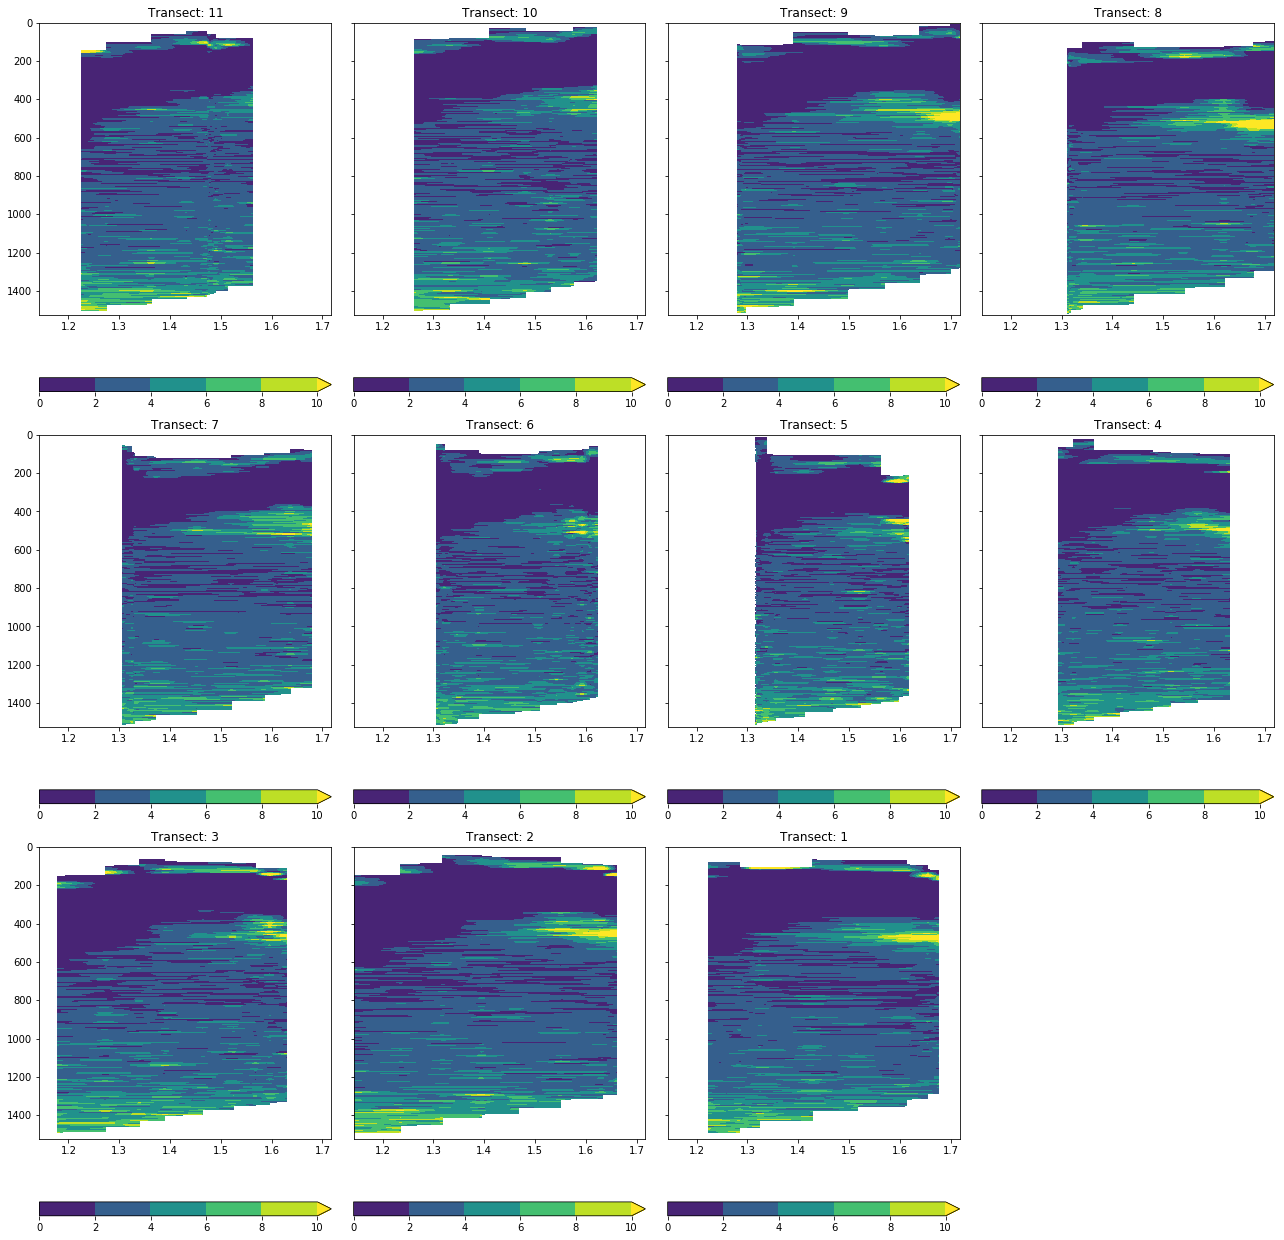

In [28]:
fig, ax = plt.subplots(3, 4, figsize=(18, 18), sharey=True)
for transect in reversed(list(transects.keys())):
    stations = transects[transect]
    gamman_lin, dz = layer_thickness(ctd['gamman'][stations], ctd['z'][stations])

    Dgrd, pgrd = np.meshgrid(D[stations], ctd['p'])
    Dgrd, pgrd = Dgrd.T, pgrd.T

    row, col = abs(transect - 11) // 4, abs(transect - 11) % 4
    
    conf = ax[row, col].contourf(Dgrd, pgrd, dz, np.linspace(0, 10, 6), extend='max')
    plt.colorbar(conf, ax=ax[row, col], orientation='horizontal')

    ax[row, col].invert_yaxis()
    ax[row, col].set_title('Transect: %s' % transect)
    ax[row, col].set_xlim([np.nanmin(D), np.nanmax(D)])
    plt.tight_layout()

fig.delaxes(ax[2][3])


/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


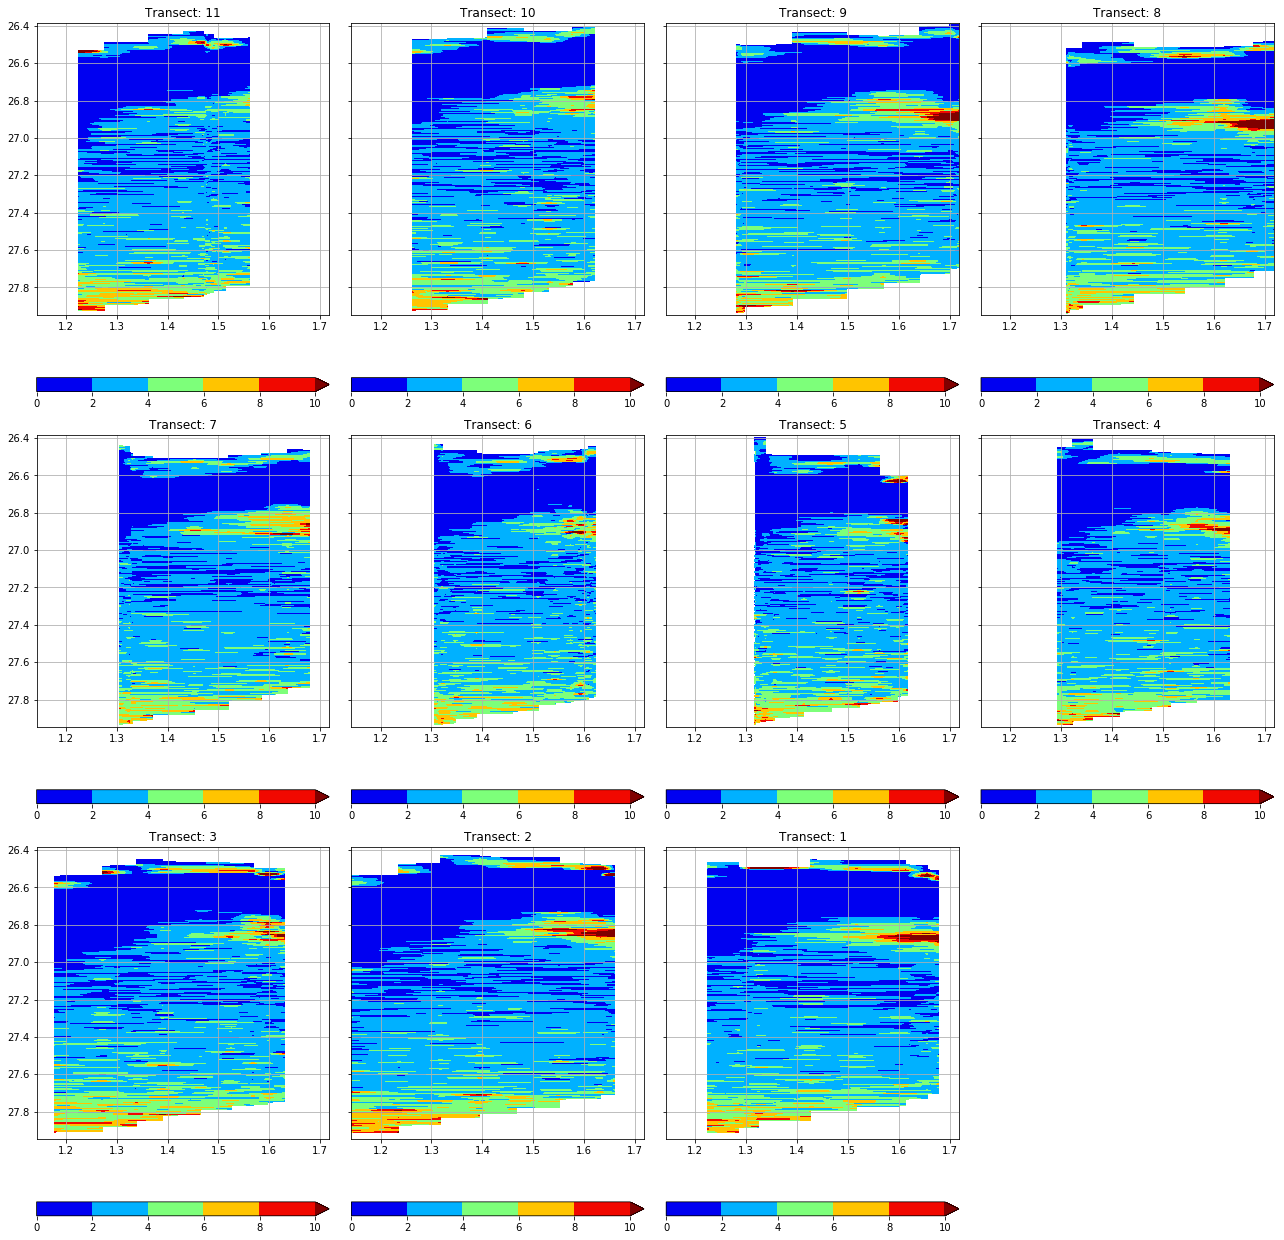

In [52]:
import cmocean as cmo
fig, ax = plt.subplots(3, 4, figsize=(18, 18), sharey=True)
for transect in reversed(list(transects.keys())):
    stations = transects[transect]
    gamman_lin, dz = layer_thickness(ctd['gamman'][stations], ctd['z'][stations])

    Dgrd, gammangrd = np.meshgrid(D[stations], gammani)
    Dgrd, gammangrd = Dgrd.T, gammangrd.T
    
    row, col = abs(transect - 11) // 4, abs(transect - 11) % 4

    conf = ax[row, col].contourf(Dgrd, gammangrd, dz, np.linspace(0, 10, 6), extend='max', cmap=plt.cm.jet)
    
    ax[row, col].invert_yaxis()
    ax[row, col].set_title('Transect: %s' % transect)
    ax[row, col].set_xlim([np.nanmin(D), np.nanmax(D)])
    ax[row, col].grid(True)

    plt.colorbar(conf, ax=ax[row, col], orientation='horizontal')
    plt.tight_layout()

fig.delaxes(ax[2][3])


In [1]:
from OceanPy.toolbox import contour_length
import xarray as xr
import pyproj

In [5]:
# load altimetry data
input_file = os.path.join(datadir, 'external', 'ssh', 'rep', 'rep_allsat_phy_l4_135_-60_160_-45_1998.nc')
ssh = xr.open_dataset(input_file)

# select data range
west = 137
south = -52.4
east = 147
north = -48

ssh = ssh.sel(longitude=slice(west, east), latitude=slice(south, north))

timevoy = slice('1998-03-10', '1998-03-28')


UTM54 = pyproj.Proj('+proj=utm +zone=54F +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs')

voyagemeancl, lon_ct, lat_ct, timemean = contour_length(ssh, 'adt', 0.15, 
                                                        time_sel=timevoy, lon_sel=slice(138, 145), 
                                                        transform=UTM54)


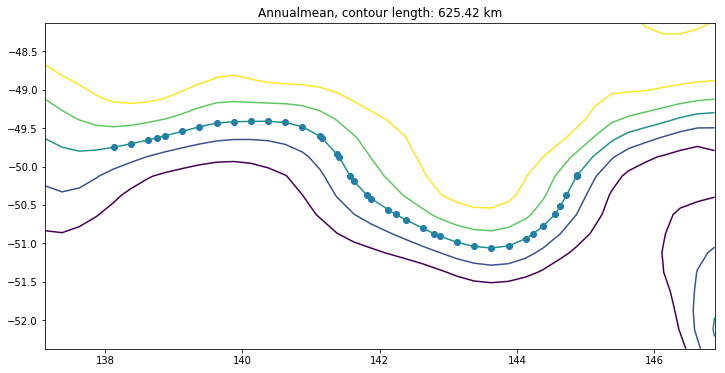

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.contour(ssh.longitude, ssh.latitude, timemean, np.linspace(-0.1, 0.4, 5))
plt.title('Voyagemean, contour length: %s km' %round(voyagemeancl/1000, 2))
plt.scatter(lon_ct, lat_ct)

In [7]:
lon_ct

array([138.125     , 138.375     , 138.625     , 138.75706459,
       138.875     , 139.125     , 139.375     , 139.625     ,
       139.875     , 140.125     , 140.375     , 140.625     ,
       140.875     , 141.125     , 141.15505705, 141.375     ,
       141.40588411, 141.57251722, 141.625     , 141.81452151,
       141.875     , 142.125     , 142.23463973, 142.375     ,
       142.625     , 142.79158072, 142.875     , 143.125     ,
       143.375     , 143.625     , 143.875     , 144.125     ,
       144.23266721, 144.375     , 144.54877852, 144.625     ,
       144.71861997, 144.86519134, 144.875     ])